In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

### A/A-тест, который сходится

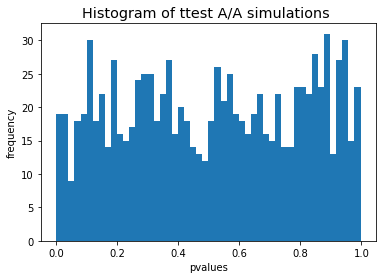

0.041

In [2]:
n = 100000
simulations = 1000
n_s = 1000
res = []

df = pd.DataFrame({
    "s1": np.random.exponential(scale=1/0.001, size=n),
    "s2": np.random.exponential(scale=1/0.001, size=n)
})

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df['s1'].sample(n_s, replace = False).values
    s2 = df['s2'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

### Второй случай, когда A/A-тест не сходится

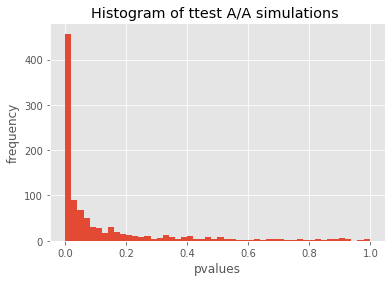

0.582

In [3]:
n = 100000
simulations = 1000
n_s = 1000
res = []

df = pd.DataFrame({
    "s1": np.random.exponential(scale=1/0.001, size=n),
    "s2": np.random.exponential(scale=1/0.001, size=n) * 1.1 # добавляем эффект 10%
})

for i in tqdm(range(simulations)):
    s1 = df['s1'].sample(n_s, replace = False).values
    s2 = df['s2'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# FPR не сойдется
sum(np.array(res) <0.05) / simulations

In [4]:
# Загрузим наши данные

In [5]:
df = pd.read_csv("hw_aa.csv", sep=";", index_col=0)
df

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...
127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


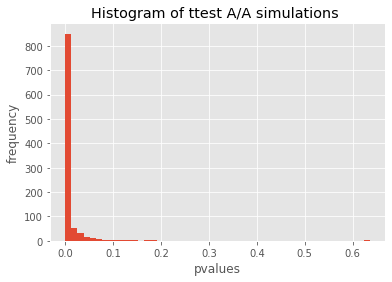

0.947

In [6]:
# запустим А/А-тест
# 

simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 0].purchase.sample(n_s, replace = False).values
    s2 = df[df.experimentVariant == 1].purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# FPR
sum(np.array(res) <0.05) / simulations

In [7]:
# полученный FPR говорит нам о том что где-то есть неправильные данные или какой-то сбой подсчета, поэтому
# посчитает конверсию

In [8]:
df.groupby(['experimentVariant', 'version'], as_index=False).agg(cr=('purchase','mean'))

,experimentVariant,version,cr
0,0,v2.8.0,0.000993
1,0,v2.9.0,0.074658
2,0,v3.7.4.0,0.059943
3,0,v3.8.0.0,0.057604
4,1,v2.8.0,0.045606
5,1,v2.9.0,0.071304
6,1,v3.7.4.0,0.063018
7,1,v3.8.0.0,0.062848


In [9]:
# Видим что группа с experimentVariant=0 и version=v2.8.0 сильно отличается от других
# запустим А/А-тест без этой группы и посмотрим на FPR

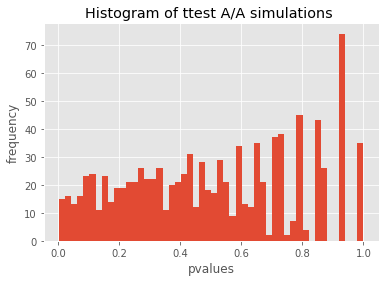

0.036

In [10]:
# запустим А/А-тест
# 

simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = df.query("experimentVariant == 0 and version != 'v2.8.0'").purchase.sample(n_s, replace = False).values
    s2 = df.query("experimentVariant == 1 and version != 'v2.8.0'").purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# FPR
sum(np.array(res) <0.05) / simulations

In [ ]:
# FPR получился менее 0.05, поэтому виновник найден - группа с experimentVariant=0 и version=v2.8.0